In [1]:
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ---- Stand-in class used during unpickling if the original class can't be imported ----
class RobotSensorSignal:
    def __init__(self, unpacked_msg):
        # match your class fields
        self.encoder_counts = int(unpacked_msg[0])
        self.steering = int(unpacked_msg[1])
        # lidar fields may exist, but plots here don't need them
        self.num_lidar_rays = int(unpacked_msg[2]) if len(unpacked_msg) > 2 else 0
        self.angles = []
        self.distances = []

class _CompatUnpickler(pickle.Unpickler):
    """
    Map missing classes (e.g., RobotSensorSignal) to local stand-ins so old logs load.
    """
    def find_class(self, module, name):
        if name == "RobotSensorSignal":
            return RobotSensorSignal
        return super().find_class(module, name)

def load_log_pkl(path: str) -> dict:
    with open(path, "rb") as f:
        try:
            return pickle.load(f)
        except Exception:
            f.seek(0)
            return _CompatUnpickler(f).load()

In [3]:
def _to_numpy_time(log):
    t = np.asarray(log["time"], dtype=float)
    # your logger often stores time in seconds already, but sometimes it's ms
    # heuristic: if typical dt > 0.5 -> it's probably ms
    if len(t) >= 2 and np.median(np.diff(t)) > 0.5:
        t = t / 1000.0
    t = t - t[0]
    return t

def extract_signals(log: dict):
    t = _to_numpy_time(log)

    # robot sensor signal: object or list
    rss = log.get("robot_sensor_signal", [])
    encoder = []
    steering = []
    for r in rss:
        if hasattr(r, "encoder_counts"):
            encoder.append(float(r.encoder_counts))
            steering.append(float(r.steering))
        else:
            # assume list-like [enc, steer, ...]
            encoder.append(float(r[0]))
            steering.append(float(r[1]))
    encoder = np.asarray(encoder, dtype=float)
    steering = np.asarray(steering, dtype=float)

    # camera sensor signal: in your pipeline it's [tx, ty, tz, rvecx, rvecy, rvecz, theta]
    cam = np.asarray(log.get("camera_sensor_signal", []), dtype=float)
    if cam.ndim == 1:
        cam = cam.reshape(1, -1)
    if cam.shape[1] >= 7:
        cam_x = cam[:, 0]
        cam_y = cam[:, 1]
        cam_th = cam[:, 6]
    else:
        cam_x = np.full_like(t, np.nan)
        cam_y = np.full_like(t, np.nan)
        cam_th = np.full_like(t, np.nan)

    # validity: matches your gating (skip if x=y=0 or NaN)
    valid = (~np.isnan(cam_x)) & (~np.isnan(cam_y)) & ~((cam_x == 0.0) & (cam_y == 0.0))

    # EKF outputs logged online (if present)
    sm = np.asarray(log.get("state_mean", []), dtype=float)
    if sm.ndim == 1:
        sm = sm.reshape(1, -1)
    if sm.shape[1] >= 3:
        ekf_x = sm[:, 0]
        ekf_y = sm[:, 1]
        ekf_th = sm[:, 2]
    else:
        ekf_x = None
        ekf_y = None
        ekf_th = None

    sc = np.asarray(log.get("state_covariance", []), dtype=float)
    # could be list of 3x3 matrices; convert to (T,3,3)
    if sc.ndim == 3 and sc.shape[1] == 3 and sc.shape[2] == 3:
        ekf_P = sc
    else:
        ekf_P = None

    return {
        "t": t,
        "encoder": encoder,
        "steering": steering,
        "cam_x": cam_x, "cam_y": cam_y, "cam_th": cam_th,
        "cam_valid": valid,
        "ekf_x": ekf_x, "ekf_y": ekf_y, "ekf_th": ekf_th,
        "ekf_P": ekf_P
    }

In [4]:
DATA_DIR = "./data"   # adjust if needed
paths = sorted(glob.glob(os.path.join(DATA_DIR, "robot_data_*.pkl")))
print(f"Found {len(paths)} logs")
paths[:5]

Found 19 logs


['./data/robot_data_0_0_04_02_26_19_07_00.pkl',
 './data/robot_data_0_0_04_02_26_19_13_26.pkl',
 './data/robot_data_0_0_04_02_26_19_38_28.pkl',
 './data/robot_data_0_0_04_02_26_19_53_05.pkl',
 './data/robot_data_0_0_11_02_26_22_06_29.pkl']

In [5]:
# ---- constants (copy from parameters.py) ----
K_SE  = 2.882760254750430982e-04
K_SS  = 6.338605358524558586e-08
A1    = -2.389748299319578351e+01
A2    =  8.136904761904759642e-01
A3    = -4.658503401360606679e-03
C_R   = -3.526364371043103914e-05
SIGMA_W2_CONST = 1.601538811297278713e-03

V_CMD_DEFAULT = 80.0

def wrap_to_pi(a):
    return (a + np.pi) % (2*np.pi) - np.pi

def r_counts_per_sec(v_cmd):
    v = np.clip(v_cmd, 40.0, 100.0)
    r = A1*v + A2*v**2 + A3*v**3
    return max(0.0, float(r))

def yaw_rate(v_cmd, alpha):
    return C_R * r_counts_per_sec(v_cmd) * float(alpha)

def run_prediction_only(sig, x0=None):
    """
    Returns predicted x,y,theta arrays using encoder + steering, skipping camera correction.
    If x0 not provided: use first valid camera pose as initial condition; else use x0.
    """
    t = sig["t"]
    enc = sig["encoder"]
    steer = sig["steering"]

    # init pose
    if x0 is None:
        if np.any(sig["cam_valid"]):
            i0 = np.where(sig["cam_valid"])[0][0]
            x = float(sig["cam_x"][i0])
            y = float(sig["cam_y"][i0])
            th = float(sig["cam_th"][i0])
        else:
            x, y, th = 0.0, 0.0, 0.0
    else:
        x, y, th = map(float, x0)

    X = np.zeros((len(t), 3), dtype=float)
    X[0] = [x, y, th]

    last_enc = float(enc[0])
    w = yaw_rate(V_CMD_DEFAULT, steer[0])

    for k in range(1, len(t)):
        dt = float(t[k] - t[k-1])
        if dt <= 0:
            dt = 1e-3

        # encoder -> distance
        de = float(enc[k] - last_enc)
        last_enc = float(enc[k])

        e_fwd = -de
        s = K_SE * e_fwd

        # yaw
        w = yaw_rate(V_CMD_DEFAULT, steer[k])
        dth = w * dt

        th_mid = th + 0.5*dth
        x = x + s*np.cos(th_mid)
        y = y + s*np.sin(th_mid)
        th = wrap_to_pi(th + dth)

        X[k] = [x, y, th]

    return X

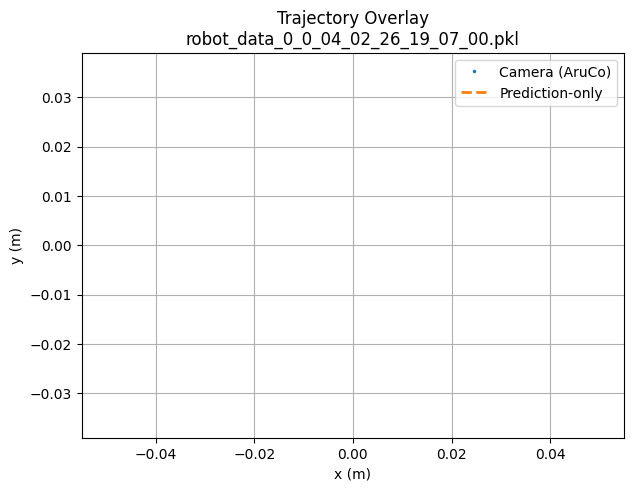

In [6]:
def plot_trajectory_overlay(path):
    log = load_log_pkl(path)
    sig = extract_signals(log)

    pred = run_prediction_only(sig)

    plt.figure(figsize=(7,5))
    # camera (valid only)
    v = sig["cam_valid"]
    plt.plot(sig["cam_x"][v], sig["cam_y"][v], '.', markersize=3, label="Camera (AruCo)")

    # online EKF (if present)
    if sig["ekf_x"] is not None:
        plt.plot(sig["ekf_x"], sig["ekf_y"], '-', linewidth=2, label="EKF (logged)")

    # prediction only
    plt.plot(pred[:,0], pred[:,1], '--', linewidth=2, label="Prediction-only")

    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title(f"Trajectory Overlay\n{os.path.basename(path)}")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.show()

# pick one file
plot_trajectory_overlay(paths[0])

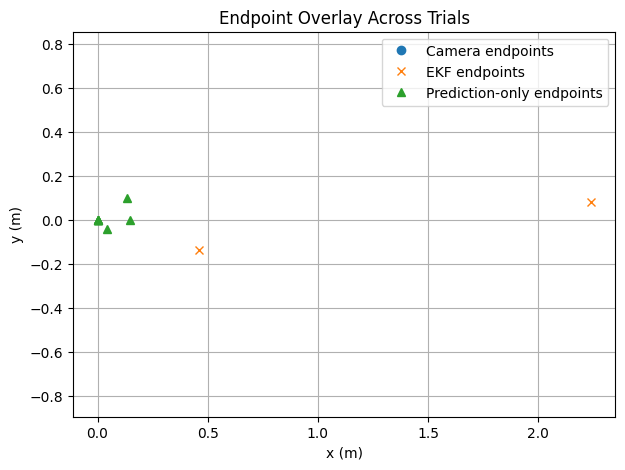

In [7]:
def plot_endpoints_overlay(paths_subset):
    cam_end = []
    ekf_end = []
    pred_end = []

    for p in paths_subset:
        log = load_log_pkl(p)
        sig = extract_signals(log)

        pred = run_prediction_only(sig)
        pred_end.append(pred[-1, :2])

        # camera final valid
        v = sig["cam_valid"]
        if np.any(v):
            i = np.where(v)[0][-1]
            cam_end.append([sig["cam_x"][i], sig["cam_y"][i]])
        else:
            cam_end.append([np.nan, np.nan])

        # EKF final (logged)
        if sig["ekf_x"] is not None:
            ekf_end.append([sig["ekf_x"][-1], sig["ekf_y"][-1]])
        else:
            ekf_end.append([np.nan, np.nan])

    cam_end = np.asarray(cam_end, float)
    ekf_end = np.asarray(ekf_end, float)
    pred_end = np.asarray(pred_end, float)

    plt.figure(figsize=(7,5))
    plt.plot(cam_end[:,0], cam_end[:,1], 'o', label="Camera endpoints")
    plt.plot(ekf_end[:,0], ekf_end[:,1], 'x', label="EKF endpoints")
    plt.plot(pred_end[:,0], pred_end[:,1], '^', label="Prediction-only endpoints")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title("Endpoint Overlay Across Trials")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.show()

# use first N trials (adjust)
plot_endpoints_overlay(paths[:8])

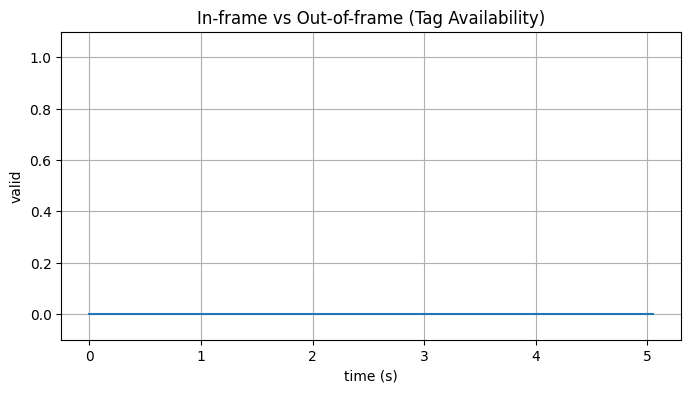

No logged state_covariance found in this file.


In [8]:
def plot_out_of_frame_cov(path):
    log = load_log_pkl(path)
    sig = extract_signals(log)

    t = sig["t"]
    valid = sig["cam_valid"].astype(int)

    plt.figure(figsize=(8,4))
    plt.plot(t, valid, label="Camera valid (1=in-frame)")
    plt.xlabel("time (s)")
    plt.ylabel("valid")
    plt.title("In-frame vs Out-of-frame (Tag Availability)")
    plt.grid(True)
    plt.ylim(-0.1, 1.1)
    plt.show()

    if sig["ekf_P"] is None:
        print("No logged state_covariance found in this file.")
        return

    P = sig["ekf_P"]
    tr_xy = np.array([np.trace(P[k][:2,:2]) for k in range(len(P))], dtype=float)

    plt.figure(figsize=(8,4))
    plt.plot(t[:len(tr_xy)], tr_xy, label="trace(P_xy)")
    plt.xlabel("time (s)")
    plt.ylabel("trace(P_xy) (m^2)")
    plt.title("Covariance Growth (Prediction-only segments increase uncertainty)")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_out_of_frame_cov(paths[0])

In [9]:
def plot_error_vs_time(path):
    log = load_log_pkl(path)
    sig = extract_signals(log)

    if sig["ekf_x"] is None:
        print("No EKF state_mean logged in this file.")
        return

    t = sig["t"]
    v = sig["cam_valid"]

    ex = sig["ekf_x"][v] - sig["cam_x"][v]
    ey = sig["ekf_y"][v] - sig["cam_y"][v]
    eth = wrap_to_pi(sig["ekf_th"][v] - sig["cam_th"][v])

    tv = t[v]

    plt.figure(figsize=(8,4))
    plt.plot(tv, ex, label="e_x (m)")
    plt.plot(tv, ey, label="e_y (m)")
    plt.plot(tv, eth, label="e_theta (rad)")
    plt.xlabel("time (s)")
    plt.ylabel("error")
    plt.title(f"EKF Error vs Camera (valid frames)\n{os.path.basename(path)}")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_error_vs_time(paths[0])

No EKF state_mean logged in this file.
